# Convolutional Recurrent Neural Network for Optical Character Recognition

## Importing the packages

In [1]:
!pip install craft-text-detector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


In [2]:
!pip install -q transformers

     |████████████████████████████████| 5.5 MB 4.9 MB/s 
     |████████████████████████████████| 182 kB 75.0 MB/s 
     |████████████████████████████████| 7.6 MB 54.9 MB/s 


In [3]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

### Dataset

You can directly download the full dataset in [this link](https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth). Since it is a huge dataset, we have used only the subset of the original dataset. The subset dataset is available in this [this link](https://drive.google.com/file/d/1SeH5VjSSCFWDVVXVK0nThlKht5xjqdiB/view?usp=share_link)

### Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/90kDICT32px.zip -d /content/90kDICT32px/

Streaming output truncated to the last 5000 lines.
  inflating: /content/90kDICT32px/8/3/448_BRIDGETOWN_9521.jpg  
  inflating: /content/90kDICT32px/8/3/449_triathletes_80584.jpg  
  inflating: /content/90kDICT32px/8/3/44_LESSEPS_44140.jpg  
  inflating: /content/90kDICT32px/8/3/450_lathes_43509.jpg  
  inflating: /content/90kDICT32px/8/3/451_Botch_8928.jpg  
  inflating: /content/90kDICT32px/8/3/452_nosing_52336.jpg  
  inflating: /content/90kDICT32px/8/3/453_Sew_69741.jpg  
  inflating: /content/90kDICT32px/8/3/454_Wilbur_86564.jpg  
  inflating: /content/90kDICT32px/8/3/455_LABIA_43005.jpg  
  inflating: /content/90kDICT32px/8/3/456_EXPROPRIATORS_27542.jpg  
  inflating: /content/90kDICT32px/8/3/457_pui_61154.jpg  
  inflating: /content/90kDICT32px/8/3/458_BARBARISM_5882.jpg  
  inflating: /content/90kDICT32px/8/3/459_immobilizes_38114.jpg  
  inflating: /content/90kDICT32px/8/3/45_Subscriptions_75669.jpg  
  inflating: /content/90kDICT32px/8/3/460_repack_64715.jpg  
  inflating: /c

In [6]:
characterset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# This function converts the characters in the text to numberical ids
def text2ids(txt):
    encoded_list = []
    for index, char in enumerate(txt):
        try:
            encoded_list.append(characterset.index(char))
        except:
            print(char)
    return encoded_list

In [7]:
# This function resizes the image with (32, 128, 1)
def rescale_img(img):
    # convert each image of shape (32, 128, 1)
    w, h = img.shape
    if h > 128 or w > 32:
        return "SKIP"
    if w < 32:
        add_zeros = np.ones((32-w, h))*255
        img = np.concatenate((img, add_zeros))

    if h < 128:
        add_zeros = np.ones((32, 128-h))*255
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.
    return img

In [8]:
images_training = []
text_training = []
len_train_input = []
len_training_label = []
original_txt_training = []

In [9]:
images_testing = []
text_testing = []
len_testing_input = []
len_testing_label = []
original_txt_testing = []

In [10]:
path = '/content/90kDICT32px'

# Data Preparation

In [11]:
max_label_len = 0

i=0
for root, dirnames, filenames in os.walk(path):
 
    for name in fnmatch.filter(filenames, '*.jpg'):
        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_BGR2GRAY)   
 
        img = rescale_img(img)
        if img == "SKIP":
            continue
        # get the text from the image
        txt = name.split('_')[1]
        
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        if i%10 == 0:     
            original_txt_testing.append(txt)   
            len_testing_label.append(len(txt))
            len_testing_input.append(31)
            images_testing.append(img)
            text_testing.append(text2ids(txt))
        else:
            original_txt_training.append(txt)   
            len_training_label.append(len(txt))
            len_train_input.append(31)
            images_training.append(img)
            text_training.append(text2ids(txt)) 
        i=i+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [12]:
train_padded_txt = pad_sequences(text_training, maxlen=max_label_len, padding='post', value = len(characterset))
valid_padded_txt = pad_sequences(text_testing, maxlen=max_label_len, padding='post', value = len(characterset))

# Model Architecture

In [13]:
inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
outputs = Dense(len(characterset)+1, activation = 'softmax')(blstm_2)

actual_model = Model(inputs, outputs)

In [14]:
actual_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

## CTC Loss Function (Spectial loss function for OCR problem)

In [15]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

## Model Training

In [16]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="/content/drive/MyDrive/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [17]:
images_training = np.array(images_training)
len_train_input = np.array(len_train_input)
len_training_label = np.array(len_training_label)

images_testing = np.array(images_testing)
len_testing_input = np.array(len_testing_input)
len_testing_label = np.array(len_testing_label)

In [18]:
batch_size = 64
epochs = 10
model.fit(x=[images_training, train_padded_txt, len_train_input, len_training_label], y=np.zeros(len(images_training)), batch_size=batch_size, epochs = epochs, validation_data = ([images_testing, valid_padded_txt, len_testing_input, len_testing_label], [np.zeros(len(images_testing))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/10
1459/1459 [==============================] - ETA: 0s - loss: 27.0643
Epoch 1: val_loss improved from inf to 26.98736, saving model to /content/drive/MyDrive/best_model.hdf5
1459/1459 [==============================] - 142s 86ms/step - loss: 27.0643 - val_loss: 26.9874
Epoch 2/10
1459/1459 [==============================] - ETA: 0s - loss: 25.8035
Epoch 2: val_loss improved from 26.98736 to 24.95718, saving model to /content/drive/MyDrive/best_model.hdf5
1459/1459 [==============================] - 128s 87ms/step - loss: 25.8035 - val_loss: 24.9572
Epoch 3/10
1459/1459 [==============================] - ETA: 0s - loss: 22.3205
Epoch 3: val_loss improved from 24.95718 to 19.34612, saving model to /content/drive/MyDrive/best_model.hdf5
1459/1459 [==============================] - 121s 83ms/step - loss: 22.3205 - val_loss: 19.3461
Epoch 4/10
1459/1459 [==============================] - ETA: 0s - loss: 13.3495
Epoch 4: val_loss improved from 19.34612 to 9.14548, saving model to /

## Predictions

In [69]:
# load the saved best model weights
actual_model.load_weights('/content/drive/MyDrive/best_model_10_epochs.hdf5')
 
# predict outputs on validation images
predicted = actual_model.predict(images_testing[50:60])
 
# use CTC decoder
output = K.get_value(K.ctc_decode(predicted, input_length=np.ones(predicted.shape[0])*predicted.shape[1],
                         greedy=True)[0][0])

1/1 [==============================] - 0s 35ms/step


-----------------Input Image-------------------


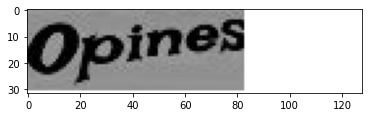

predicted text = Opines

-----------------Input Image-------------------


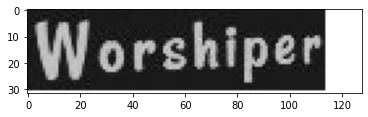

predicted text = Worshiper

-----------------Input Image-------------------


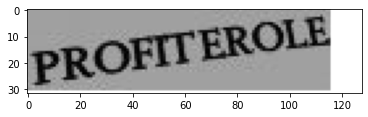

predicted text = PROFITEROLE

-----------------Input Image-------------------


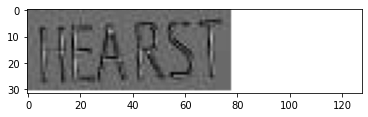

predicted text = TEARST

-----------------Input Image-------------------


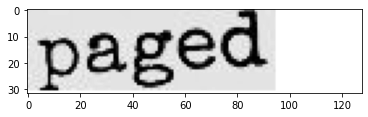

predicted text = paged

-----------------Input Image-------------------


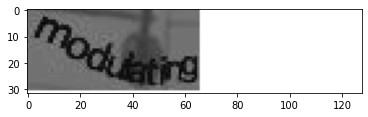

predicted text = mociatirg

-----------------Input Image-------------------


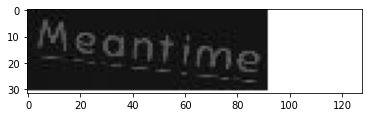

predicted text = Meantime

-----------------Input Image-------------------


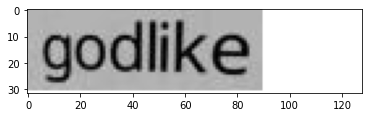

predicted text = godlike

-----------------Input Image-------------------


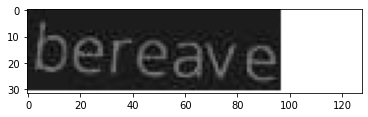

predicted text = bereave

-----------------Input Image-------------------


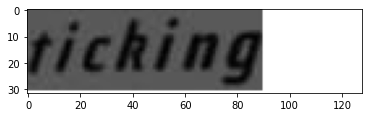

predicted text = ticking



In [70]:
import matplotlib.pyplot as plt

i = 50
for word in output:
    print("-----------------Input Image-------------------")
    plt.imshow(images_testing[i].reshape(32,128), cmap='gray')
    plt.show()
    print("predicted text = ", end = '')
    for char in word:  
        if int(char) != -1:
            print(characterset[int(char)], end = '')       
    print('\n')
    i+=1

# Sentiment Analysis

In [71]:
from craft_text_detector import Craft

def get_image_crop(image):
  output_dir = 'outputs/'
  # create a craft instance
  craft = Craft(crop_type="poly", cuda=False,output_dir=output_dir)

  # apply craft text detection and export detected regions to output directory
  prediction_result = craft.detect_text(image)
  print("Image adjusted crop saved")
  print("Image path is : /content/outputs/{}_crops/crop_0.png".format(image.split(".")[0]))
  return "/content/outputs/"+image.split(".")[0]+"_crops/crop_0.png"

In [72]:
image = 'positive.png'
cropped_path = get_image_crop(image)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Image adjusted crop saved
Image path is : /content/outputs/positive_crops/crop_0.png


In [73]:
cropped_path

'/content/outputs/positive_crops/crop_0.png'

In [74]:
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd

def get_character_coordinates(cropped_path):
  img = cv2.imread(cropped_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(gray,50,255,0)
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  boxes = []
  for con in contours:
      if len(con)!=4:
          x,y,w,h = cv2.boundingRect(con)
          boxes.append([x,y,w,h])
          img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
  cv2_imshow(img)
  df = pd.DataFrame(boxes, columns =['x','y','w','h']) 
  df.sort_values(by=['x'],inplace=True)
  return df

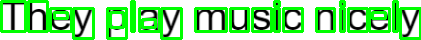

,x,y,w,h
24,1,1,24,30
23,28,1,19,30
17,50,8,21,23
18,54,12,13,6
16,73,8,20,30
14,107,8,19,30
15,110,12,13,15
22,131,1,3,30
12,139,8,20,23
13,142,19,13,8


In [75]:
df = get_character_coordinates(cropped_path)
df

In [76]:
import shutil

def get_cropped_words(cropped_path,df):
  if os.path.exists('words'):
    shutil.rmtree('words', ignore_errors=True)
  os.mkdir('words')
  image = cv2.imread(cropped_path)
  x_min=0
  y_min=0
  y_max=image.shape[0]
  word_count=1
  last = len(df.values)
  for i,row in enumerate(df.values):
      if i==0:
          x_max=row[0]+row[2]
      elif i==last-1:
          cropped_image = image[y_min:y_max, x_min:image.shape[1]]
          cv2.imwrite('words/word{}.png'.format(word_count),cropped_image)
          print("The word saved in path : words/word{}.png".format(word_count))        
      else:
          if row[0]-x_max>10:
              mid = (x_max+row[0])//2
              cropped_image = image[y_min:y_max, x_min:mid]
              x_min=mid
              x_max=row[0]+row[2]
              cv2.imwrite('words/word{}.png'.format(word_count),cropped_image)
              print("The word saved in path : words/word{}.png".format(word_count))
              word_count+=1
          else :
              x_max=row[0]+row[2]

In [77]:
get_cropped_words(cropped_path,df)

The word saved in path : words/word1.png
The word saved in path : words/word2.png
The word saved in path : words/word3.png
The word saved in path : words/word4.png


In [78]:
def image_padding(words_path):
  words = sorted(os.listdir(words_path))
  for word in words:
    image = cv2.imread('/content/words/'+str(word))
    print(word)
    if image.shape[1]<128:
      padding_range = 128 - image.shape[1]
      x = padding_range//2
      white = [255,255,255]
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      constant= cv2.copyMakeBorder(image.copy(),0,0,x,x,cv2.BORDER_CONSTANT,value=white)
      constant = cv2.resize(constant, (128, 32))
      cv2_imshow(constant)
      print(constant.shape)
      cv2.imwrite('words/'+str(word),constant)
    else :
      constant = cv2.resize(image, (128, 32))
      cv2_imshow(constant)
      print(constant.shape)
      cv2.imwrite('words/'+str(word),constant)

word1.png


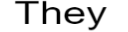

(32, 128)
word2.png


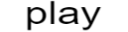

(32, 128)
word3.png


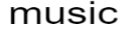

(32, 128)
word4.png


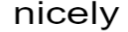

(32, 128)


In [79]:
image_padding('/content/words/')

In [80]:
def get_validation_images(words_path):
  words = sorted(os.listdir(words_path))
  val_images = []
  for word in words:
    img = cv2.cvtColor(cv2.imread(words_path+word), cv2.COLOR_BGR2GRAY)
    plt.imshow(img, cmap='gray')
    plt.show()
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    val_images.append(img)

  # Normalize each image
  val_images = np.array(val_images)
  print(val_images.shape)
  return val_images

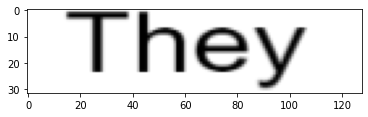

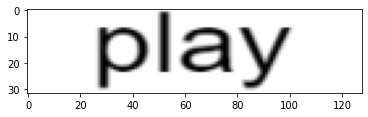

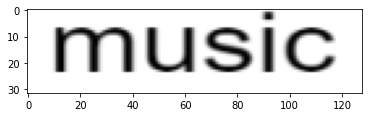

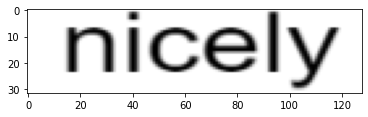

(4, 32, 128, 1)


In [81]:
val_images = get_validation_images('/content/words/')

In [82]:
def get_predictions(val_images):
  prediction = actual_model.predict(val_images)

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                          greedy=True)[0][0])
  i = 0
  words = []
  for x in out:
      print("predicted text = ", end = '')
      wrd = []
      for p in x:  
          if int(p) != -1:
              print(characterset[int(p)], end = '') 
              wrd.extend(characterset[int(p)])    
      print('\n')
      words.append(wrd)
      i+=1
  return ["".join(wrd) for wrd in words]

In [83]:
predicted_words = get_predictions(val_images)

1/1 [==============================] - 0s 26ms/step
predicted text = They

predicted text = rplay

predicted text = music

predicted text = nicely



In [84]:
predicted_words

['They', 'rplay', 'music', 'nicely']

In [85]:
from textblob import Word

def spelling_correction(words):
  corrected_sentence = []
  for j in words:
    word = Word(j)
    corrected_sentence.append(word.correct())
  return " ".join(corrected_sentence)

In [86]:
corrected_sentence = spelling_correction(predicted_words)
corrected_sentence

'They play music nicely'

In [87]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [88]:
print("The input sentence is : ",corrected_sentence)
print(sentiment_pipeline([corrected_sentence]))

The input sentence is :  They play music nicely
[{'label': 'POSITIVE', 'score': 0.9998751878738403}]


In [89]:
image = 'negative.png'
cropped_path = get_image_crop(image)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Image adjusted crop saved
Image path is : /content/outputs/negative_crops/crop_0.png


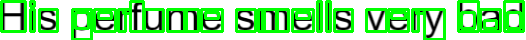

,x,y,w,h
36,1,1,24,30
27,30,9,4,22
35,30,1,4,5
26,39,9,18,22
24,72,9,19,30
25,75,12,13,16
22,94,9,21,22
23,98,12,13,6
21,118,9,7,22
20,123,9,7,4


In [90]:
df = get_character_coordinates(cropped_path)
df

In [91]:
get_cropped_words(cropped_path,df)

The word saved in path : words/word1.png
The word saved in path : words/word2.png
The word saved in path : words/word3.png
The word saved in path : words/word4.png
The word saved in path : words/word5.png


word1.png


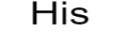

(32, 128)
word2.png


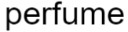

(32, 128, 3)
word3.png


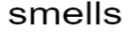

(32, 128, 3)
word4.png


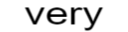

(32, 128)
word5.png


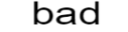

(32, 128)


In [92]:
image_padding('/content/words/')

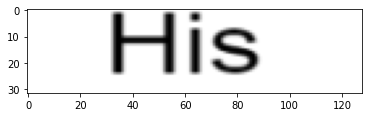

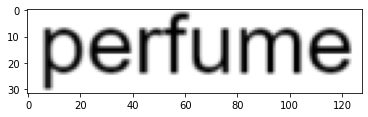

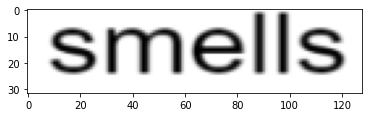

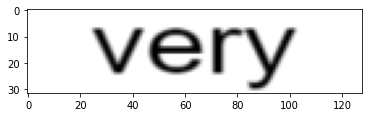

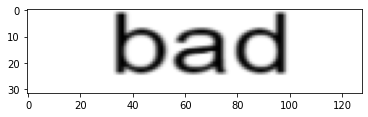

(5, 32, 128, 1)


In [93]:
val_images = get_validation_images('/content/words/')

In [94]:
predicted_words = get_predictions(val_images)

1/1 [==============================] - 0s 25ms/step
predicted text = eHis

predicted text = perfume

predicted text = smells

predicted text = very

predicted text = ibad



In [95]:
corrected_sentence = spelling_correction(predicted_words)
corrected_sentence

'his perfume smells very bad'

In [96]:
print("The input sentence is : ",corrected_sentence)
print(sentiment_pipeline([corrected_sentence]))

The input sentence is :  his perfume smells very bad
[{'label': 'NEGATIVE', 'score': 0.9997778534889221}]
